In [1]:
# Single notebook cell: Load from MongoDB (last 5 days), feature engineering, tuning, stacking, save, optional auto-retrain
import os
import time
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import joblib
from dotenv import load_dotenv
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None


In [ ]:
# ---------------------------
# CONFIG
# ---------------------------
load_dotenv()  # loads MONGODB_URI etc from .env
MONGODB_URI = os.getenv("MONGODB_URI")
DB_NAME = os.getenv("DB_NAME", "stock-price-prediction")   # match your DB name
STOCK_LIST = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA",
              "META", "NFLX", "NVDA", "IBM", "ORCL"]       # your 10 symbols
LOOKBACK_DAYS = 30   # last 5 days used for training
MODEL_PATH = "best_stock_model.pkl"
SCALER_PATH = "scaler.pkl"

In [ ]:
# ---------------------------
# Helpers
# ---------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / (loss.replace(0, 1e-8))
    return 100 - (100 / (1 + rs))

def connect_mongo(uri):
    if not uri:
        raise RuntimeError("MONGODB_URI not provided in environment")
    client = MongoClient(uri)
    return client

def load_last_n_days_from_mongo(client, db_name, symbols, days=30):
    db = client[db_name]
    now_utc = datetime.utcnow()
    start = now_utc - timedelta(days=days)
    all_frames = []
    for sym in symbols:
        coll = db[sym.upper()]
        cursor = coll.find({"Date": {"$gte": start}})
        df = pd.DataFrame(list(cursor))
        if df.empty:
            print(f" No records for {sym} in last {days} days — skipped")
            continue
        # Ensure Date column is datetime
        if "_id" in df.columns and "Date" not in df.columns:
            df["Date"] = df["_id"]
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date").reset_index(drop=True)
        df["symbol"] = sym.upper()
        # Keep only expected numeric columns
        expected_cols = ["Date", "Open", "High", "Low", "Close", "Volume", "Adj_Close", "symbol"]
        for c in expected_cols:
            if c not in df.columns:
                df[c] = np.nan
        df = df[expected_cols]
        all_frames.append(df)
        print(f"Loaded {len(df)} rows for {sym}")
    if not all_frames:
        return pd.DataFrame()  # nothing loaded
    combined = pd.concat(all_frames, ignore_index=True)
    combined = combined.sort_values(["symbol","Date"]).reset_index(drop=True)
    return combined

In [ ]:
# ---------------------------
# UPDATED Feature Engineering (Dynamic indicators)
# ---------------------------
def add_features(df_all):
    df_all = df_all.copy()

    def fe_group(g):
        g = g.sort_values("Date").reset_index(drop=True)
        rows = len(g)

        print(f"[{g['symbol'].iloc[0]}] Rows available = {rows}")

        # ================================
        # PRIORITY 1 → FULL INDICATORS
        # Need 50 rows (MA50 requires 50)
        # ================================
        if rows >= 50:
            print(" → Using FULL indicators (RSI14, MA20, MA50)...")

            g["RSI14"] = compute_rsi(g["Close"], 14)
            g["MA20"] = g["Close"].rolling(20).mean()
            g["MA50"] = g["Close"].rolling(50).mean()

            # lag features
            g["Close_1"] = g["Close"].shift(1)
            g["Close_2"] = g["Close"].shift(2)
            g["Close_3"] = g["Close"].shift(3)
            g["Close_5"] = g["Close"].shift(5)

        # ================================
        # PRIORITY 2 → MEDIUM INDICATORS
        # Need ≥ 20 rows
        # ================================
        elif rows >= 20:
            print(" → Using MEDIUM indicators (RSI7, MA10)...")

            g["RSI7"] = compute_rsi(g["Close"], 7)
            g["MA10"] = g["Close"].rolling(10).mean()

            g["Close_1"] = g["Close"].shift(1)
            g["Close_2"] = g["Close"].shift(2)
            g["Close_3"] = g["Close"].shift(3)

        # ================================
        # PRIORITY 3 → SMALL INDICATORS
        # Need ≥ 14 rows
        # ================================
        elif rows >= 14:
            print(" → Using SMALL indicators (RSI7 only + lags)...")

            g["RSI7"] = compute_rsi(g["Close"], 7)

            g["Close_1"] = g["Close"].shift(1)
            g["Close_2"] = g["Close"].shift(2)

        # ================================
        # PRIORITY 4 → MINIMAL FEATURES
        # Need ≥ 7 rows
        # Only lag features
        # ================================
        elif rows >= 7:
            print(" → Using MINIMAL features (lags only)...")

            g["Close_1"] = g["Close"].shift(1)
            g["Close_2"] = g["Close"].shift(2)

        # ================================
        # PRIORITY 5 → TOO LITTLE DATA
        # Skip this stock entirely
        # ================================
        else:
            print(" - Not enough data (< 7 rows), skipping this symbol")
            return pd.DataFrame()

        # Target: next candle direction
        g["target"] = (g["Close"].shift(-1) > g["Close"]).astype(int)

        # Drop unusable rows (indicator warmups)
        g = g.dropna().reset_index(drop=True)
        return g

    # Apply per symbol
    df_fe = df_all.groupby("symbol", group_keys=False).apply(fe_group)

    print("Final feature-engineered shape:", df_fe.shape)
    return df_fe


In [10]:
# ---------------------------
# Training pipeline
# ---------------------------
def train_and_save_model(df_all, feature_cols=None):
    if df_all.empty:
        print("No data available to train.")
        return None, None

    if feature_cols is None:
        feature_cols = [
            'Open','High','Low','Close','Volume',
            'return_1','return_3','return_7',
            'sma_5','sma_10','sma_20','ema_10','ema_20',
            'vol_5','vol_10','mom_3','mom_7',
            'vol_change','vol_ratio_5','rsi_14',
            'month','dayofweek','is_quarter_end',
            'close_lag_1','close_lag_2','close_lag_3','close_lag_5',
            'vol_lag_1','vol_lag_2','vol_lag_3','vol_lag_5'
        ]

    # ensure all features exist
    missing = [c for c in feature_cols if c not in df_all.columns]
    if missing:
        print("Warning - missing features, dropping:", missing)
        feature_cols = [c for c in feature_cols if c in df_all.columns]

    X = df_all[feature_cols].copy()
    y = df_all["target"].copy()

    # sort by time globally, preserve time order for split
    df_all = df_all.sort_values("Date").reset_index(drop=True)
    split_index = int(len(df_all) * 0.8)
    X_train = X.iloc[:split_index]
    X_valid = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_valid = y.iloc[split_index:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Models & param grids
    models_to_try = {}
    param_grids = {}

    models_to_try['rf'] = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grids['rf'] = {
        'n_estimators': [200, 400],
        'max_depth': [4, 6, 8],
        'class_weight': [None, 'balanced']
    }

    try:
        from xgboost import XGBClassifier
        models_to_try['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
        param_grids['xgb'] = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    except Exception:
        print("xgboost not available - skipping")

    try:
        from lightgbm import LGBMClassifier
        models_to_try['lgbm'] = LGBMClassifier(random_state=42, n_jobs=-1)
        param_grids['lgbm'] = {
            'n_estimators': [100, 200],
            'max_depth': [-1, 6],
            'learning_rate': [0.01, 0.05, 0.1]
        }
    except Exception:
        print("lightgbm not available - skipping")

    print("Models available for tuning:", list(models_to_try.keys()))
    tscv = TimeSeriesSplit(n_splits=3)
    best_estimators = {}
    validation_aucs = {}

    for name, model in models_to_try.items():
        print(f"\nTuning {name} ...")
        grid = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids.get(name, {}),
            n_iter=8,
            scoring='roc_auc',
            cv=tscv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        grid.fit(X_train_scaled, y_train)
        best = grid.best_estimator_
        best_estimators[name] = best

        if hasattr(best, "predict_proba"):
            y_valid_proba = best.predict_proba(X_valid_scaled)[:, 1]
        else:
            try:
                y_valid_proba = best.decision_function(X_valid_scaled)
                y_valid_proba = (y_valid_proba - y_valid_proba.min()) / (y_valid_proba.max() - y_valid_proba.min() + 1e-8)
            except Exception:
                y_valid_proba = best.predict(X_valid_scaled)

        auc = roc_auc_score(y_valid, y_valid_proba)
        validation_aucs[name] = auc
        print(f" Best params ({name}):", grid.best_params_)
        print(f" Validation AUC ({name}): {auc:.4f}")

    # choose top 3 for stacking
    sorted_models = sorted(validation_aucs.items(), key=lambda x: x[1], reverse=True)
    print("\nValidation AUCs (sorted):", sorted_models)
    top_k = min(3, len(sorted_models))
    top_names = [t[0] for t in sorted_models[:top_k]]
    estimators_for_stack = [(name, best_estimators[name]) for name in top_names]

    print("Stacking models:", top_names)
    final_estimator = LogisticRegression()
    stack = StackingClassifier(
        estimators=estimators_for_stack,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=False
    )

    print("\nTraining final stacking model ...")
    stack.fit(X_train_scaled, y_train)

    if hasattr(stack, "predict_proba"):
        y_valid_proba_stack = stack.predict_proba(X_valid_scaled)[:, 1]
    else:
        y_valid_proba_stack = stack.predict(X_valid_scaled)

    auc_stack = roc_auc_score(y_valid, y_valid_proba_stack)
    y_valid_pred = stack.predict(X_valid_scaled)
    print(f"\nStacking Validation AUC: {auc_stack:.4f}")
    print("\nClassification report (stack):\n", classification_report(y_valid, y_valid_pred))

    # Confusion matrix display (optional in notebook)
    try:
        ConfusionMatrixDisplay.from_estimator(stack, X_valid_scaled, y_valid)
        plt.title("Confusion Matrix - Stacking")
        plt.show()
    except Exception:
        pass

    # Save stack and scaler
    joblib.dump(stack, MODEL_PATH)
    joblib.dump(scaler, SCALER_PATH)
    print(f"\nSaved: {MODEL_PATH} and {SCALER_PATH}")

    return stack, scaler

In [11]:
# ---------------------------
# Orchestration: load -> fe -> train
# ---------------------------
def retrain_from_mongo(days=LOOKBACK_DAYS):
    client = connect_mongo(MONGODB_URI)
    raw = load_last_n_days_from_mongo(client, DB_NAME, STOCK_LIST, days=days)
    if raw.empty:
        print("No data loaded from MongoDB. Aborting retrain.")
        return None
    df_fe = add_features(raw)
    print("Feature-engineered dataset shape:", df_fe.shape)
    stack, scaler = train_and_save_model(df_fe)
    return stack, scaler

In [ ]:
# ---------------------------
# Optional: Background retrain scheduler (every N days)
# ---------------------------
def start_auto_retrain(every_n_days=30, run_immediately=False):
    """
    Starts a background scheduler that runs retrain_from_mongo every `every_n_days`.
    Call this only when you want continuous retraining (not recommended inside shared notebook servers).
    """
    from apscheduler.schedulers.background import BackgroundScheduler
    scheduler = BackgroundScheduler()
    scheduler.add_job(lambda: retrain_from_mongo(days=LOOKBACK_DAYS), 'interval', days=every_n_days, next_run_time=(datetime.now() if run_immediately else None))
    scheduler.start()
    print(f"Auto-retrain scheduled every {every_n_days} days. (BackgroundScheduler started)")
    return scheduler

Starting retrain job (single run)...
Loaded 21 rows for AAPL
Loaded 21 rows for MSFT
Loaded 21 rows for GOOGL
Loaded 21 rows for AMZN
Loaded 21 rows for TSLA
Loaded 21 rows for META
Loaded 21 rows for NFLX
Loaded 21 rows for NVDA
Loaded 21 rows for IBM
Loaded 21 rows for ORCL
[AAPL] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[AMZN] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[GOOGL] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[IBM] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[META] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[MSFT] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[NFLX] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[NVDA] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[ORCL] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
[TSLA] Rows available = 21
 → Using MEDIUM indicators (RSI7, MA10)...
Final feature-engineere

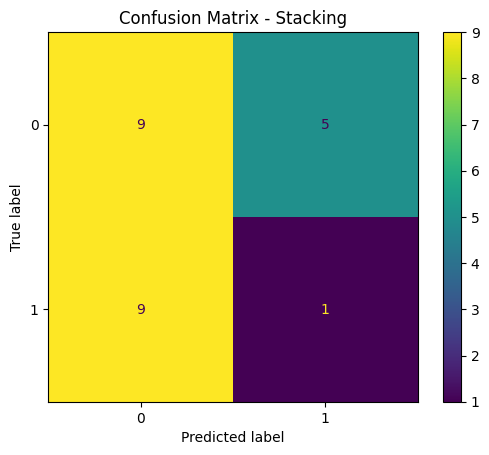


Saved: best_stock_model.pkl and scaler.pkl


In [13]:
# ---------------------------
# Run single retrain now
# ---------------------------
if __name__ == "__main__" or True:
    print("Starting retrain job (single run)...")
    retrain_from_mongo(days=LOOKBACK_DAYS)